# Optimize a dense network with Bayesian optimization
Authors: Thong Nguyen

In [1]:
!fusermount -u drive

fusermount: failed to unmount /content/drive: No such file or directory


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'machine-learning-vbscan/'

Mounted at /content/gdrive


## Usual setup: Loading `pandas` DataFrames, creating training and testing dataset


In [0]:
import uproot
import numpy as np
import pandas as pd
import h5py

# baseline keras model
from keras.models import Sequential, Model
from keras.optimizers import SGD
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten
from keras.utils import np_utils
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

import time

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

treename = 'HZZ4LeptonsAnalysisReduced'
filename = {}
upfile = {}
params = {}
df = {}

filename['VV'] = base_dir+'data/ntuple_4mu_VV.root'
filename['bkg'] = base_dir+'data/ntuple_4mu_bkg.root'

VARS = ['f_mass4l','f_massjj'] # choose which vars to use (2d)

upfile['VV'] = uproot.open(filename['VV'])
params['VV'] = upfile['VV'][treename].arrays(VARS)
upfile['bkg'] = uproot.open(filename['bkg'])
params['bkg'] = upfile['bkg'][treename].arrays(VARS)

df['VV'] = pd.DataFrame(params['VV'],columns=VARS)
df['bkg'] = pd.DataFrame(params['bkg'],columns=VARS)

# cut out undefined variables VARS[0] and VARS[1] > -999
df['VV']= df['VV'][(df['VV'][VARS[0]] > -999) & (df['VV'][VARS[1]] > -999)]
df['bkg']= df['bkg'][(df['bkg'][VARS[0]] > -999) & (df['bkg'][VARS[1]] > -999)] 

# add isSignal variable
df['VV']['isSignal'] = np.ones(len(df['VV'])) 
df['bkg']['isSignal'] = np.zeros(len(df['bkg'])) 

df_all = pd.concat([df['VV'],df['bkg']])
dataset = df_all.values

NDIM = len(VARS)

X = dataset[:,0:NDIM]
Y = dataset[:,NDIM]

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

# preprocessing: standard scalar
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X_train_val)
X_train_val = scaler.transform(X_train_val)
X_test = scaler.transform(X_test)

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# model checkpoint callback
# this saves our model architecture + parameters into dense_model.h5
model_checkpoint = ModelCheckpoint('dense_model.h5', monitor='val_loss', 
                                   verbose=0, save_best_only=True, 
                                   save_weights_only=False, mode='auto', 
                                   period=1)

In [12]:
!pip install scikit-optimize 

  Using cached https://files.pythonhosted.org/packages/f4/44/60f82c97d1caa98752c7da2c1681cab5c7a390a0fdd3a55fac672b321cac/scikit_optimize-0.5.2-py2.py3-none-any.whl


## Optimize the hyperparameters of the model
The hyperperparameters of the model that we weill optimize are the number of hidden layers `num_hidden`, the number of nodes in each layer `initial_node`, and the fraction of dropout `dropout`.

In [14]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

def build_custom_model(num_hiddens=2, initial_node=50, 
                          dropout=0.5):
    inputs = Input(shape=(NDIM,), name = 'input')
    for i in range(num_hiddens):
        hidden = Dense(int(round(initial_node/np.power(2,i))), activation='relu')(inputs if i==0 else hidden)
        hidden = Dropout(np.float32(dropout))(hidden)
    outputs = Dense(1, name = 'output', kernel_initializer='normal', activation='sigmoid')(hidden)
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

def train(model, batch_size=1000):
    history = model.fit(X_train_val, 
                    Y_train_val, 
                    epochs=100, 
                    batch_size=batch_size, 
                    verbose=0, # switch to 1 for more verbosity 
                    callbacks=[early_stopping, model_checkpoint], 
                    validation_split=0.25)
    best_acc = max(history.history['val_acc'])
    return best_acc

space  = [Integer(1, 3, name='hidden_layers'),
          Integer(5, 100, name='initial_nodes'),
          Real(0.0,0.9,name='dropout'),
          Integer(500,5000,name='batch_size'),
          Real(10**-5, 10**-1, "log-uniform", name='learning_rate'),
          ]

@use_named_args(space)
def objective(**X):
    print("New configuration: {}".format(X))

    model = build_custom_model(num_hiddens=X['hidden_layers'], initial_node=X['initial_nodes'], 
                      dropout=X['dropout'])

    model.compile(optimizer=optimizers.Adam(lr=X['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()

    best_acc = train(model, batch_size=X['batch_size'])
        
    print("Best acc: {}".format(best_acc))
    return -best_acc

begt = time.time()
res_gp = gp_minimize(objective, space, n_calls=20, random_state=3)
print("Finish optimization in {}s".format(time.time()-begt))

New configuration: {'dropout': 0.10919572308469448, 'hidden_layers': 1, 'learning_rate': 0.0005600770399424082, 'batch_size': 3062, 'initial_nodes': 85}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 85)                255       
_________________________________________________________________
dropout_1 (Dropout)          (None, 85)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 86        
Total params: 341
Trainable params: 341
Non-trainable params: 0
__

## Visualize the improvement
Let's see how Bayesian optimization improves the accuracy

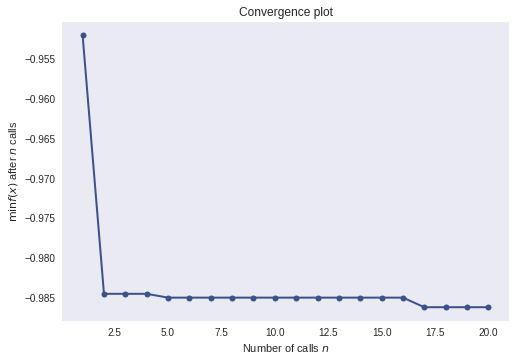

In [15]:
from skopt.plots import plot_convergence
plot_convergence(res_gp)

In [16]:
print("Best parameters: \
\nbest_hidden_layers = {} \
\nbest_initial_nodes = {} \
\nbest_dropout = {} \
\nbest_batch_size = {} \
\nbest_learning_rate = {}".format(res_gp.x[0],
                                 res_gp.x[1],
                                 res_gp.x[2],
                                 res_gp.x[3],
                                 res_gp.x[4]))


Best parameters: 
best_hidden_layers = 2 
best_initial_nodes = 100 
best_dropout = 0.0 
best_batch_size = 500 
best_learning_rate = 0.1
